# Générer des images grâce aux encodeurs

Un **autoencodeur** est un modèle de réseau de neurones qui apprend à représenter les données en les compressant dans un **espace latent de dimension réduite**, puis à les reconstruire à partir de cette représentation comprimée. L'objectif principal est de créer une représentation compacte des données d'entrée tout en conservant les caractéristiques importantes.

# Fonctionnement des Autoencodeurs

Les autoencodeurs sont des modèles de réseaux de neurones utilisés pour réduire la dimensionnalité des données, reconstruire des images, générer de nouvelles données, ou détecter des anomalies. Voici comment ils fonctionnent :

1. **Structure de Base** : Un autoencodeur est composé de deux parties principales : l'encodeur et le décodeur.

2. **Encodeur** : L'encodeur prend les données d'entrée et les transforme en une représentation de dimension réduite dans l'espace latent. Il utilise généralement des couches de convolution et des couches denses pour extraire des caractéristiques importantes des données.

3. **Décodeur** : Le décodeur prend la représentation de l'espace latent et la reconstruit pour obtenir une version proche des données d'entrée d'origine. Il utilise des opérations de convolution transposée et des couches denses pour effectuer cette reconstruction.

4. **Objectif** : Pendant l'apprentissage, l'autoencodeur minimise la différence entre les données d'entrée et les données de sortie reconstruites. Cela oblige le modèle à apprendre à représenter les données de manière efficace dans l'espace latent.

5. **Applications** :
   - **Réduction de Dimensionnalité** : Les autoencodeurs réduisent la dimension des données pour faciliter la visualisation et l'analyse.
   - **Reconstruction d'Images** : Ils sont utilisés pour reconstruire des images à partir d'une représentation compressée.
   - **Génération d'Images** : Les autoencodeurs variationnels (VAE) génèrent de nouvelles images en échantillonnant l'espace latent.
   - **Détection d'Anomalies** : Ils détectent des anomalies en comparant la qualité de la reconstruction.
   - **Compression d'Images** : Ils compriment des images pour économiser de l'espace de stockage ou de transmission.




![Texte alternatif](autoencodeur.png)

![Texte alternatif](auto.png)

In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, callbacks
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

In [ ]:
# Les paramètres

In [2]:
# Taille des images d'entrée
IMAGE_SIZE = 32
# Nombre de canaux de couleur de l'image (1 pour niveaux de gris, 3 pour RVB)
CHANNELS = 1
# Taille du lot (batch) pour l'entraînement du modèle
BATCH_SIZE = 100
# Taille du tampon (buffer) pour le mélange des données
BUFFER_SIZE = 1000
# Proportion des données réservée pour la validation pendant l'entraînement
VALIDATION_SPLIT = 0.2
# Dimension de l'espace latent (représentation compressée des images)
EMBEDDING_DIM = 2
# Nombre d'époques d'entraînement du modèle
EPOCHS = 3


# Étape 1 : Chargement de l'ensemble de données Fashion MNIST

In [3]:

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Définition de la fonction preprocess qui prend une variable imgs en entrée
def preprocess(imgs):
    """
    Normalise et remodèle les images.

    Args:
        imgs (numpy.ndarray): Les images d'origine à prétraiter.

    Returns:
        numpy.ndarray: Les images prétraitées avec une normalisation des valeurs et un remodelage.
    """

    # Normalisation : Conversion des valeurs des pixels en virgule flottante entre 0 et 1
    imgs = imgs.astype("float32") / 255.0

    # Remodelage de l'image : Ajout de zéros autour de chaque image
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

    # Ajout d'une dimension pour indiquer le canal (1 pour niveaux de gris)
    imgs = np.expand_dims(imgs, -1)

    # Renvoie les images prétraitées
    return imgs



x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [4]:
# Affichons quelques articles vestimentaires de l'ensemble d'entraînement
display(x_train)

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

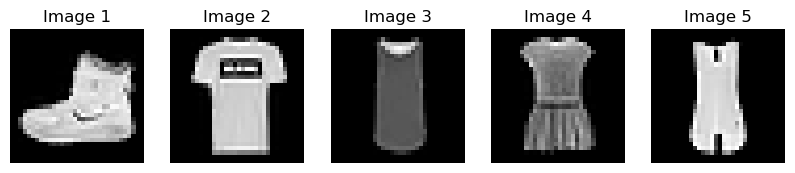

In [5]:

# Affichage de quelques images d'entraînement
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')  # Afficher l'image en niveaux de gris
    plt.title("Image {}".format(i + 1))
    plt.axis('off')
plt.show()


# Étape 2 : Définition du modèle autoencodeur

## Encodeur

Dans cette étape, nous définissons l'encodeur, qui est la première moitié du modèle autoencodeur. L'encodeur transforme l'image d'entrée en une représentation compacte dans l'espace latent.Sa principale fonction est **de réduire la dimension des données d'entrée tout en préservant les caractéristiques importantes**. 



In [6]:
# Définition de l'entrée de l'encodeur avec la taille de l'image et le nombre de canaux
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)

# Couche de convolution 1 : 32 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)

# Couche de convolution 2 : 64 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# Couche de convolution 3 : 128 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

# Sauvegarde de la forme avant l'aplatissage, nécessaire pour le décodeur
shape_before_flattening = K.int_shape(x)[1:]

# Aplatissement de la sortie des couches de convolution
x = layers.Flatten()(x)

# Couche dense pour la représentation compressée de dimension EMBEDDING_DIM
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

# Création du modèle de l'encodeur
encoder = models.Model(encoder_input, encoder_output)

# Affichage du résumé de l'encodeur
encoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

Dans cette étape, nous allons explorer la deuxième moitié du modèle autoencodeur, appelée le décodeur. Alors que l'encodeur se concentre sur la réduction de dimensionnalité tout en préservant les caractéristiques clés de l'image d'entrée, le décodeur accomplit l'inverse : il prend la représentation compacte de l'espace latent et la rétablit en une image reconstruite.

## Decodeur

In [7]:
# Définition de l'entrée du décodeur avec la dimension de l'espace latent
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

# Couche dense pour préparer la sortie du décodeur
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)

# Remise en forme de la sortie pour correspondre à la forme avant l'aplatissage
x = layers.Reshape(shape_before_flattening)(x)

# Couche de convolution transposée 1 : 128 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# Couche de convolution transposée 2 : 64 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# Couche de convolution transposée 3 : 32 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# Couche de sortie avec le nombre de canaux (CHANNELS) et activation sigmoïde
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

# Création du modèle du décodeur
decoder = models.Model(decoder_input, decoder_output)

# Affichage du résumé du décodeur
decoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [8]:
# Autoencodeur
autoencodeur = models.Model(
    encoder_input, decoder(encoder_output)
)  # décodeur(encoder_output)
autoencodeur.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

In [9]:


# Étape 3 : Compilation du modèle
autoencodeur.compile(optimizer="adam", loss="binary_crossentropy")

In [10]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [11]:
# Étape 4 : Entraînement du modèle
autoencodeur.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
599/600 [============================>.] - ETA: 0s - loss: 0.2969INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 27s 44ms/step - loss: 0.2968 - val_loss: 0.2637
Epoch 2/3
599/600 [============================>.] - ETA: 0s - loss: 0.2598INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 28s 46ms/step - loss: 0.2598 - val_loss: 0.2586
Epoch 3/3
599/600 [============================>.] - ETA: 0s - loss: 0.2559INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 28s 47ms/step - loss: 0.2559 - val_loss: 0.2558


In [12]:
# Sauvegarde des modèles finaux
autoencodeur.save("./models/autoencodeur")  # Sauvegarde du modèle autoencodeur complet
encoder.save("./models/encodeur")  # Sauvegarde du modèle d'encodeur
decoder.save("./models/decodeur")  # Sauvegarde du modèle de décodeur


INFO:tensorflow:Assets written to: ./models/autoencodeur/assets


INFO:tensorflow:Assets written to: ./models/autoencodeur/assets


INFO:tensorflow:Assets written to: ./models/encodeur/assets


INFO:tensorflow:Assets written to: ./models/encodeur/assets


INFO:tensorflow:Assets written to: ./models/decodeur/assets


INFO:tensorflow:Assets written to: ./models/decodeur/assets


In [13]:


# Étape 5 : Évaluation du modèle
# Calcul de l'erreur de reconstruction
loss = autoencodeur.evaluate(x_test, x_test)
print("Erreur de reconstruction sur l'ensemble de test : {:.4f}".format(loss))


313/313 [==============================] - 4s 11ms/step - loss: 0.2558
Erreur de reconstruction sur l'ensemble de test : 0.2558


In [14]:
# Prediction des images
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [15]:
predictions = autoencodeur.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

157/157 [==============================] - 2s 10ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[1.35128801e-06],
         [5.53208785e-08],
         [1.66020968e-07],
         ...,
         [4.77546607e-08],
         [1.26117087e-07],
         [7.11546818e-06]],

        [[6.03808736e-09],
         [3.89402871e-10],
         [1.04023394e-08],
         ...,
         [4.29863256e-09],
         [1.20216912e-08],
         [7.67767801e-07]],

        [[2.56125681e-08],
         [1.11341842e-08],
         [1.10203575e-06],
         ...,
         [3.43749252e-06],
         [6.31697446e-07],
         [1.13492597e-05]],

        ...,

        [[2.07997953e-13],
         [1.12884225e-12],
         [2.42888234e-07],
         ...,
         [3.03445233e-08],
         [1.26525845e-09],
         [2.87907778e-08]],

        [[9.75855681e-12],
         [5.92138144e-12],
         [3.96420674e-08],
         ...,
         [1.11257670e-10],
         [8.66430955e-11],
         [2.62527795e-08]],

        [[4.52468925e-07],
         [2.34171921e-07],
         [2.65601466e-06],
         ...,
 

Exemples de vêtements réels
Reconstructions


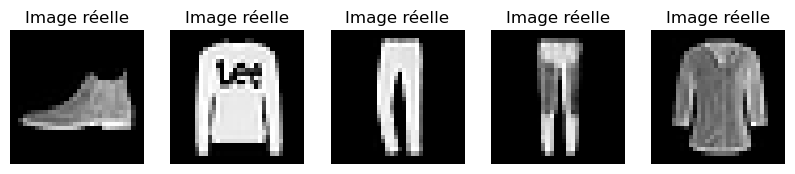

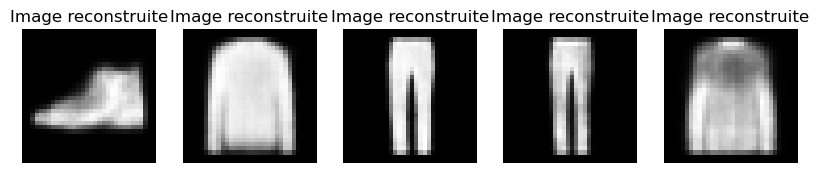

In [16]:
# Affichage des vraies images
print("Exemples de vêtements réels")
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(example_images[i].reshape(32, 32), cmap='gray')
    plt.title("Image réelle")
    plt.axis('off')

# Affichage des images reconstruites
print("Reconstructions")
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(predictions[i].reshape(32, 32), cmap='gray')
    plt.title("Image reconstruite")
    plt.axis('off')

plt.show()

# Embedding

Dans un autoencodeur, l'embedding représente une version compressée des données d'entrée, réduite en dimension, qui capture l'essentiel de ces données pour diverses applications telles que la réduction de dimension ou la génération de données similaires. C'est une représentation compacte et informativement dense des données d'origine.

In [17]:
# Encodage des images
embeddings = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [18]:
# Quelques exemples
print(embeddings[:10])

[[  2.5045016   -4.983488  ]
 [ -1.1025172    0.3411599 ]
 [-13.002832    -0.65959096]
 [-12.41314     -3.0605273 ]
 [ -1.2221609   -1.6974906 ]
 [ -7.016545    -0.75642383]
 [ -2.1041625   -3.2972126 ]
 [ -1.6239471   -2.133375  ]
 [ -0.15767846  -9.152181  ]
 [  1.0201733   -7.0380864 ]]


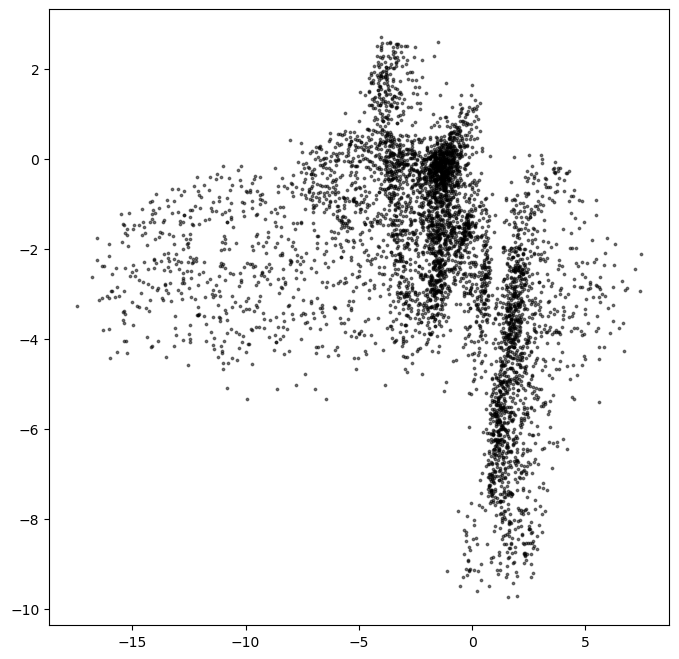

In [19]:
# Afficher les points encodés dans un espace en 2D.
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

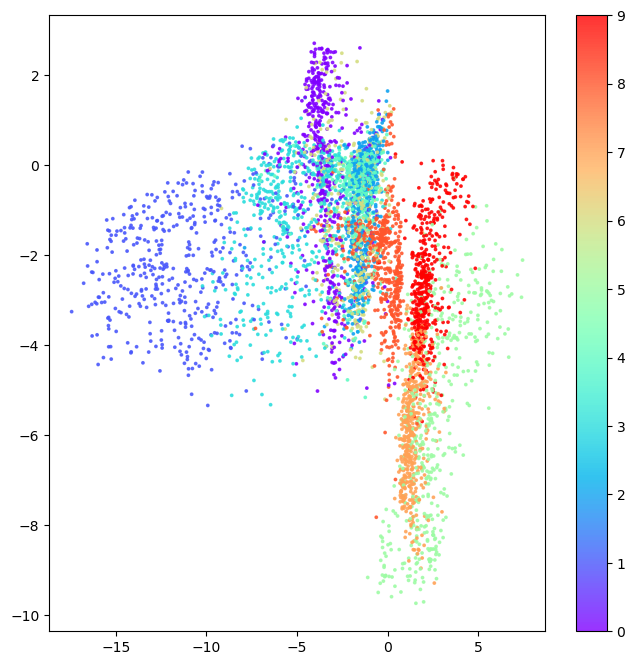

In [20]:
# affichage en fonction du type
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [21]:
# Obtenir la plage des valeurs existantes
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Échantillonner quelques points dans l'espace latent
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)


In [22]:
# Décoder les points échantillonnés
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 38ms/step


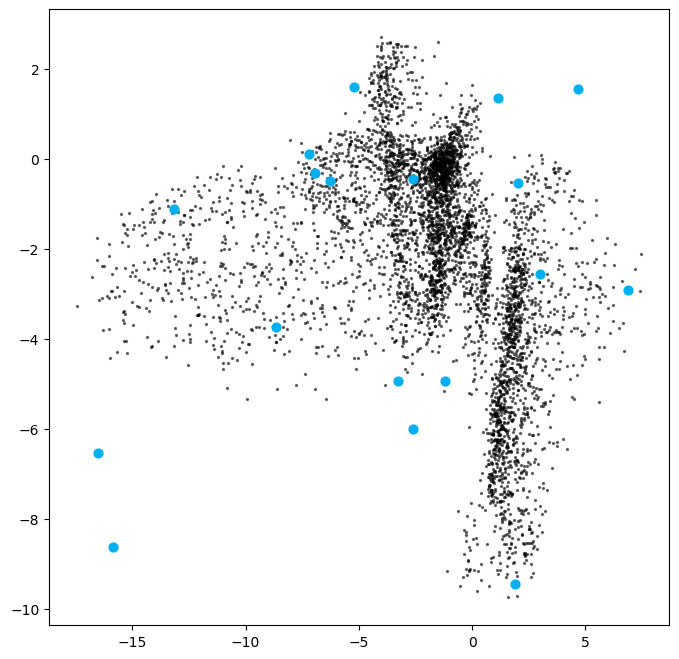

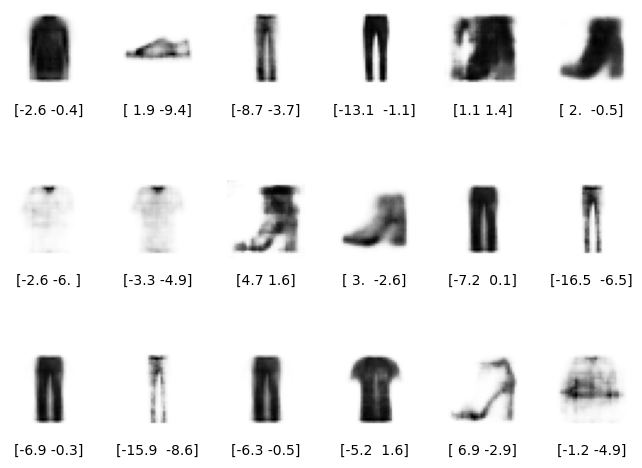

In [23]:
# Dessiner un graphique...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... des embeddings originaux ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... et des nouveaux points générés dans l'espace latent
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Ajouter en dessous une grille des images décodées
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")


8/8 [==============================] - 0s 11ms/step


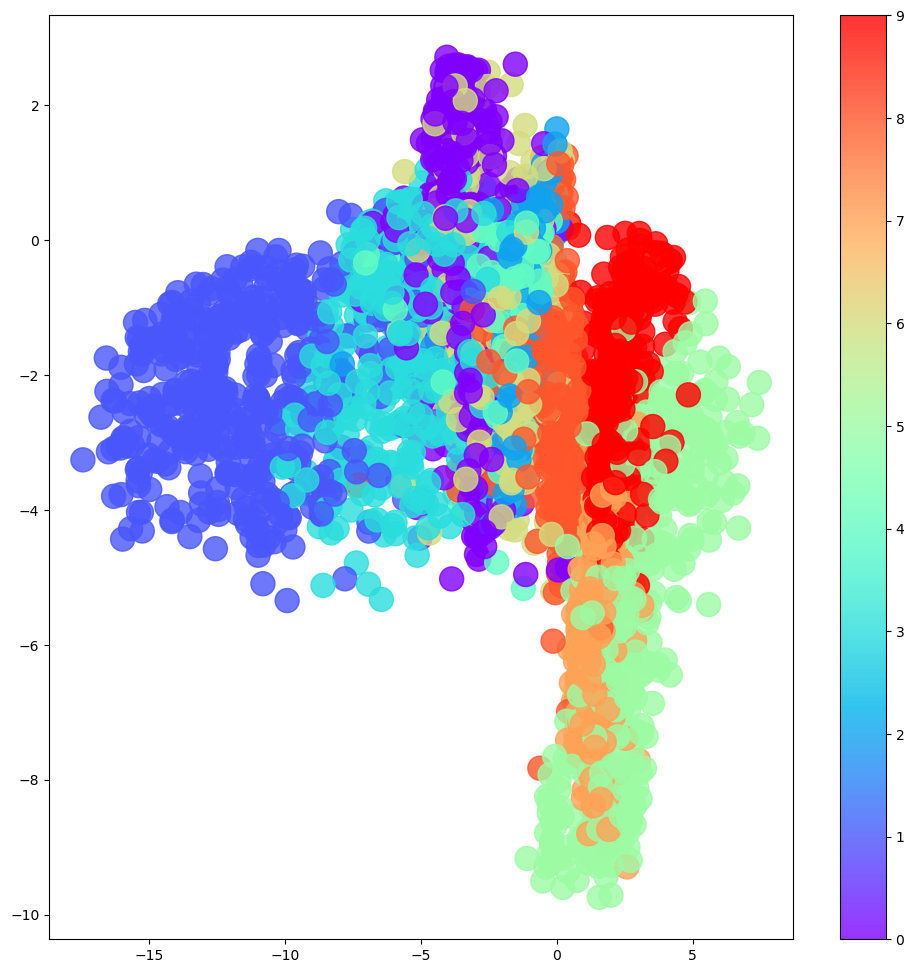

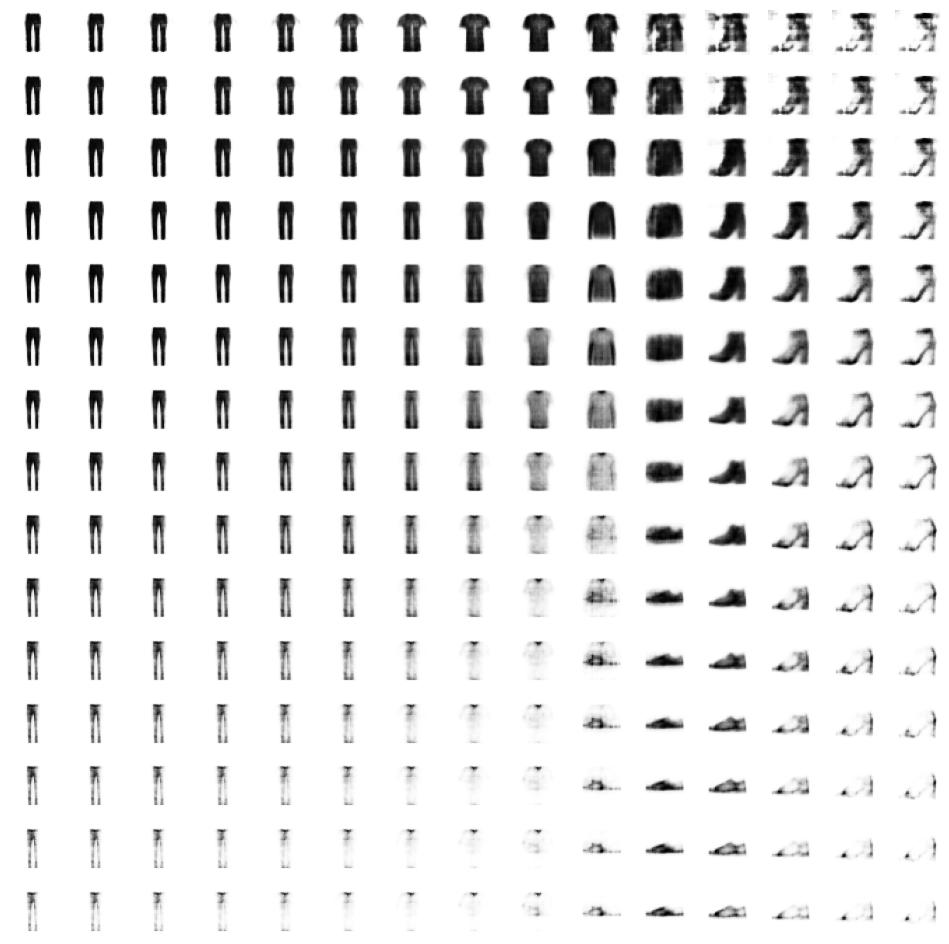

In [24]:
# Colorer les embeddings en fonction de leur label (type de vêtement - voir la table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")


# Quiz 

##. Quiz Jour5
### Question 1

Quel type de réseau de neurones est principalement utilisé pour la classification d'images ?


A) CNN (Convolutional Neural Network)

B) RNN (Recurrent Neural Network)

C) MLP (Multilayer Perceptron)



### Question 2

Pourquoi ajouter des couches de dropout dans un réseau de neurones ?

A) Pour augmenter le nombre de paramètres du modèle.

B) Pour réduire le surapprentissage en désactivant aléatoirement certains neurones pendant l'entraînement.

C) Pour accélérer le processus d'entraînement.


### Question 3

À quoi sert le transfert learning en apprentissage automatique ?

A) Transfert d'argent entre comptes bancaires

B) Utilisation de modèles pré-entraînés sur des tâches similaires pour résoudre de nouveaux problèmes

C) Transfert de fichiers entre ordinateurs

## Quiz Jour 6

1-Quelle est la fonction principale d'un autoencodeur ?

a. Compression de données en utilisant un algorithme de cryptage.


b. Réduction de la dimensionnalité des données tout en préservant leurs caractéristiques importantes.


c. Génération de données aléatoires.


2-Quelles sont les deux parties principales d'un autoencodeur ?


a. L'encodeur et le décodeur.


b. Le compresseur et le décompresseur.


c. Le crypteur et le décrypteur.


3-Comment fonctionne le processus d'apprentissage d'un autoencodeur ?

a. L'encodeur convertit les données en une représentation simplifiée, puis le décodeur les reconstruit, et l'erreur de reconstruction est minimisée.


b. L'encodeur crypte les données, puis le décodeur les décrypte pour l'analyse.


c. L'autoencodeur n'apprend pas, il effectue simplement une transformation fixe des données.
